# Numerical results

### Load packages

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

# 1D Dam-break problem

In [11]:
# Load the .mat file
mat_data = loadmat('data/dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])

# Load the numerical solution
mat_data = loadmat('data/1D-dam-break-verification.mat')

q = mat_data['q'] 
x = mat_data['x']

h_num = q[0, :]
hu_num = q[1, :]

N = 200 # Number of grid points
L = 50 # Length of the domain
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)


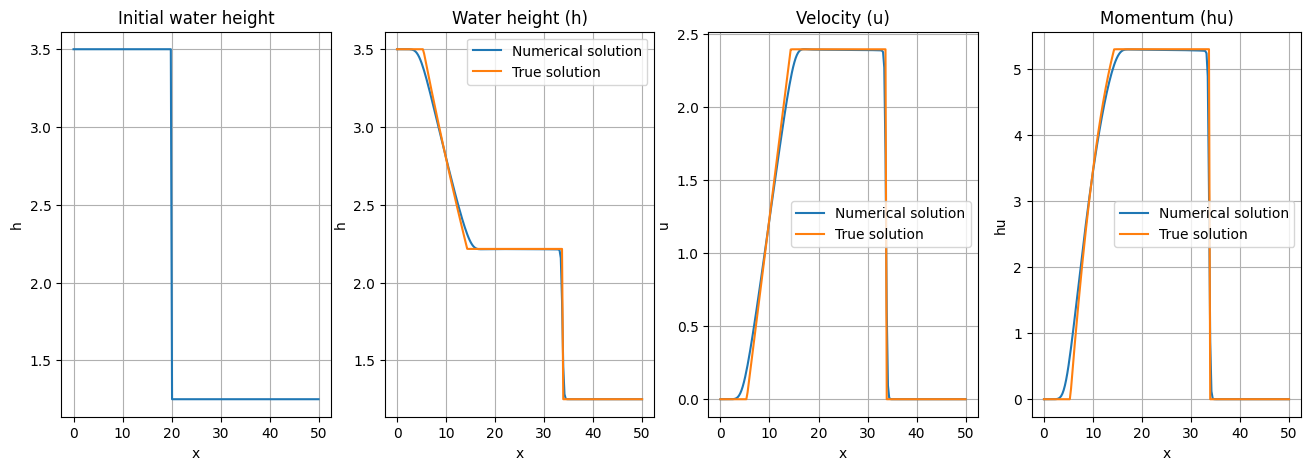

In [12]:
save = 1

# Plot the numerical solution
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.plot(x, h)
plt.xlabel('x')
plt.ylabel('h')
plt.grid()
plt.title('Initial water height')

plt.subplot(1, 4, 2)
plt.plot(x, h_num, label='Numerical solution')
plt.plot(x, h_sol, label='True solution')
plt.xlabel('x')
plt.ylabel('h')
plt.legend()
plt.grid()
plt.title('Water height (h)')

plt.subplot(1, 4, 3)
plt.plot(x, hu_num/h_num, label='Numerical solution')
plt.plot(x, u_sol, label='True solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.title('Velocity (u)')

plt.subplot(1, 4, 4)
plt.plot(x, hu_num, label='Numerical solution')
plt.plot(x, u_sol*h_sol, label='True solution')
plt.xlabel('x')
plt.ylabel('hu')
plt.legend()
plt.grid()
plt.title('Momentum (hu)')

# Save figure
if save:
    plt.savefig('plots/sol_1D_val.pdf', format='pdf')

plt.show()


# Toro test cases

In [13]:
# FLUX CHOICE
# 1--> Godunov method with exact Rieamnn problem
# 2--> Lax-Friedrichs
# 3--> Lax-Wendroff
# 4--> FORCE
# 5--> HLLC
# 6--> Flux-splitting (2020) UPWIND

save = 1

## Test 1

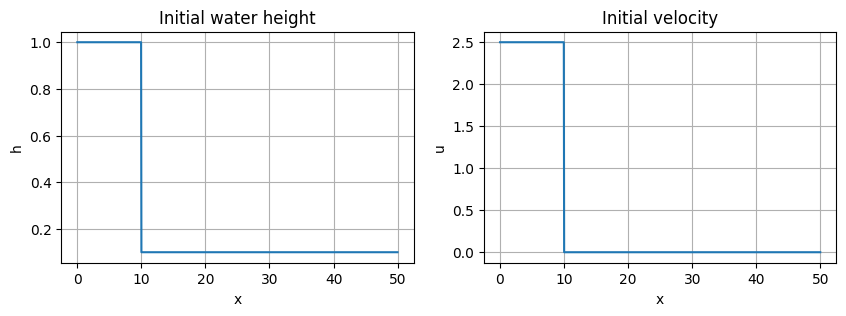

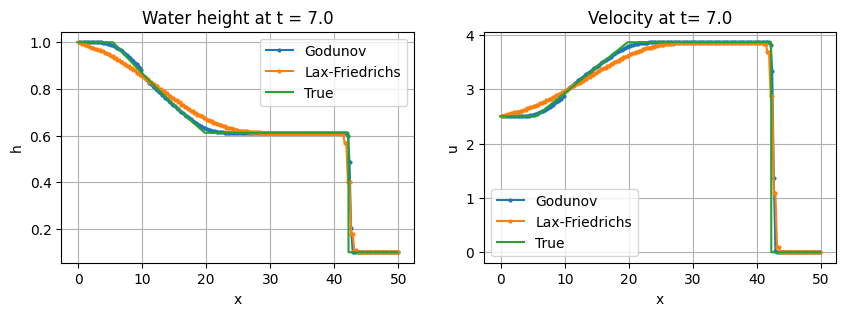

In [14]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 7.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.1
uL = 2.5
uR = 0.0
x0 = 10.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test1_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab
mat_data = loadmat('data/torotest1flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest1flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest1flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest1flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest1flux5.mat')
h_HLLC = mat_data['h']
u_HLLC = mat_data['u']

mat_data = loadmat('data/torotest1flux6.mat')
h_FS = mat_data['h']
u_FS = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_GOD[0,:], '-o', markersize = 2)
plt.plot(xc[0,:], h_LF[0,:], '-o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :])
plt.legend(['Godunov', 'Lax-Friedrichs', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_GOD[0,:], '-o', markersize = 2)
plt.plot(xc[0,:], u_LF[0,:], '-o', markersize = 2)
plt.plot(xexact[0, :], uexact[0, :])
plt.legend(['Godunov', 'Lax-Friedrichs', 'True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test1_final.pdf', format='pdf')

plt.show()

## Test 2

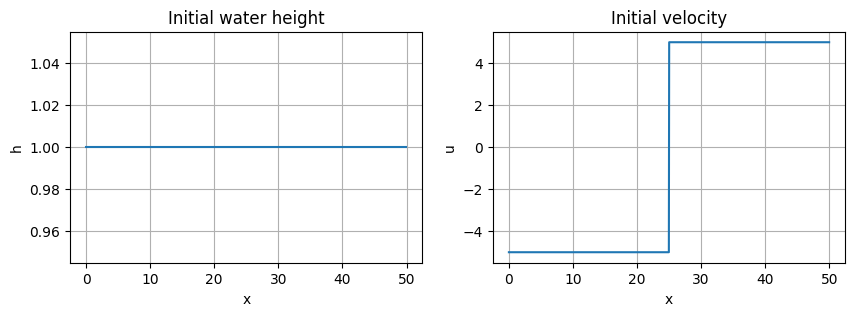

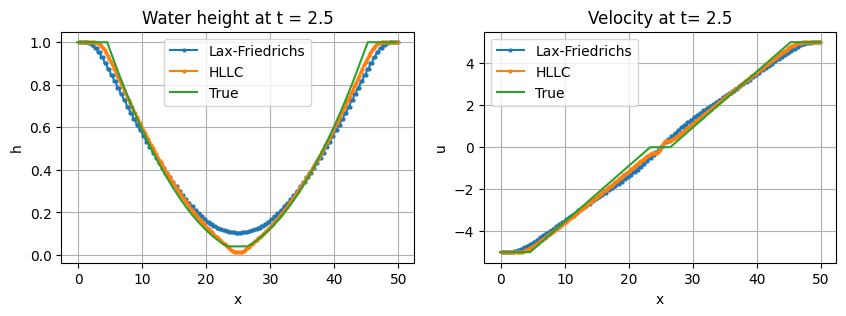

In [15]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 2.5

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 1.0
uL = -5.0
uR = 5.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test2_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest2flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest2flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest2flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest2flux5.mat')
h_HLLC = mat_data['h']
u_HLLC = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], '-o', markersize = 2)
plt.plot(xc[0,:], h_HLLC[0,:], '-o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], '-o', markersize = 2)
plt.plot(xc[0,:], u_HLLC[0,:], '-o', markersize = 2)
plt.plot(xexact[0, :], uexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test2_final.pdf', format='pdf')

plt.show()

## Test 3

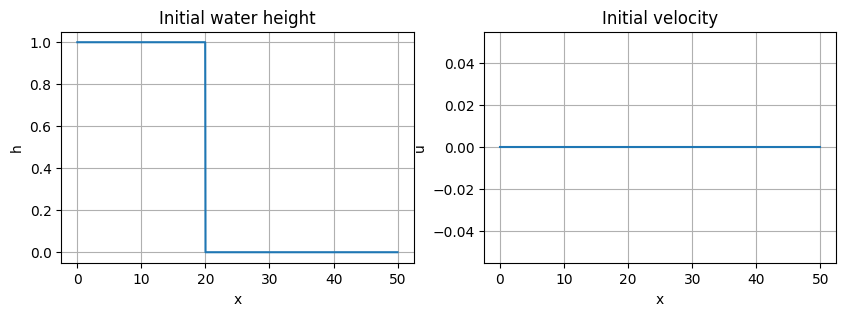

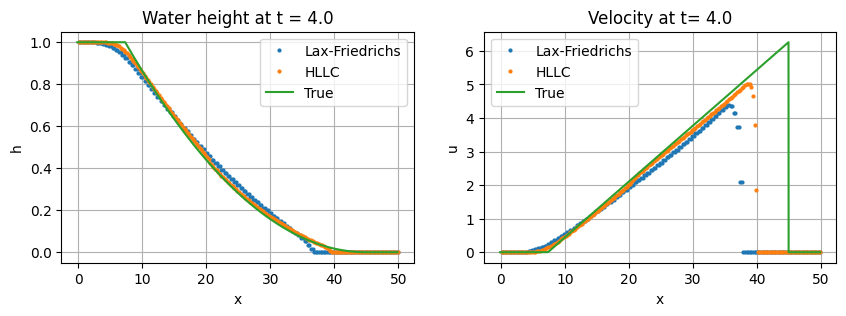

In [16]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.0
uL = 0.0
uR = 0.0
x0 = 20.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test3_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest6flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

mat_data = loadmat('data/torotest3flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']

# Load other numerical solutions
mat_data = loadmat('data/torotest3flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest3flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest3flux5.mat')
h_HLLC = mat_data['h']
u_HLLC = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], h_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], u_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], uexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test3_final.pdf', format='pdf')

plt.show()

## Test 4

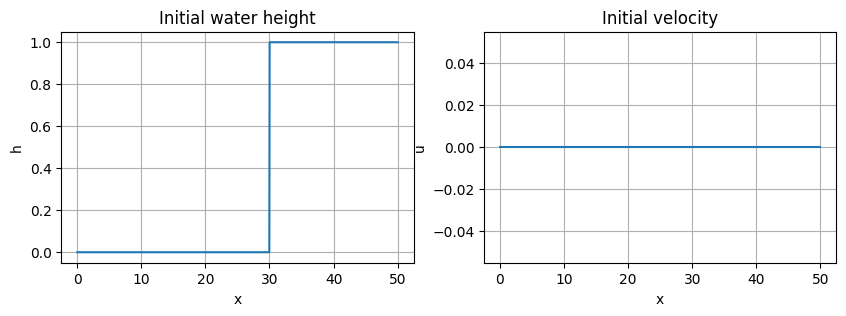

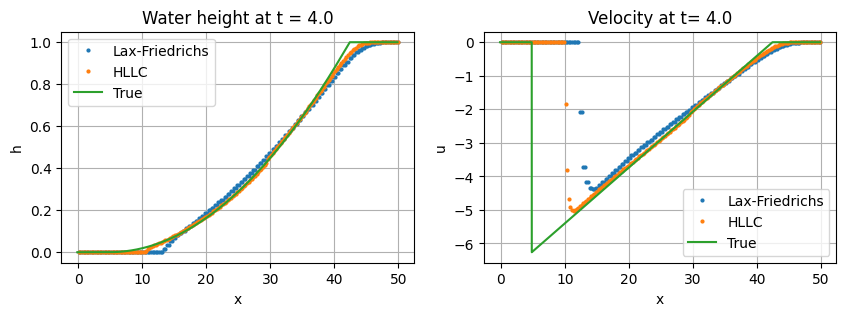

In [17]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.0
hR = 1.0
uL = 0.0
uR = 0.0
x0 = 30.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test4_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest7flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest4flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest4flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest4flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest4flux5.mat')
h_HLLC = mat_data['h']
u_HLLC = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], h_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], u_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], uexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test4_final.pdf', format='pdf')

plt.show()

## Test 5

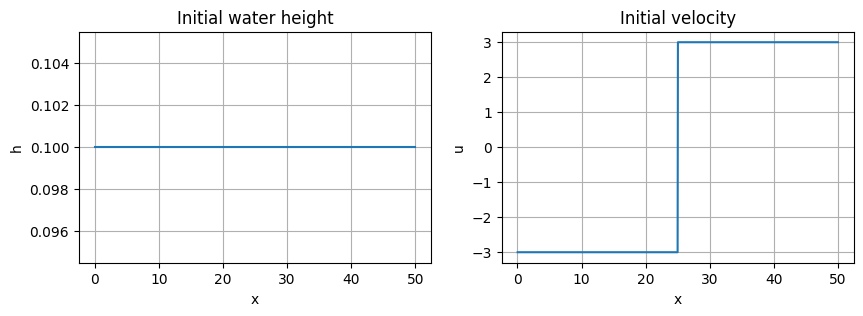

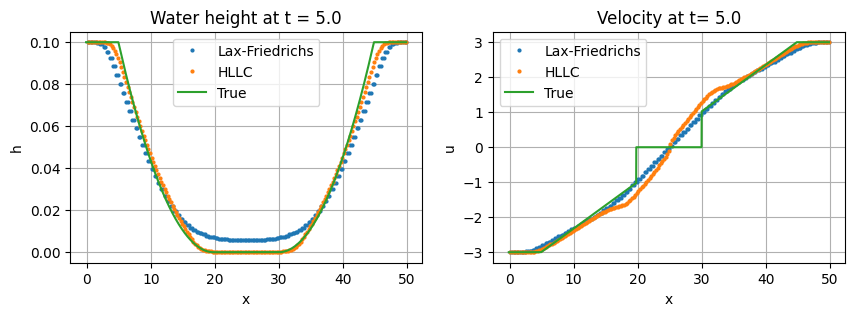

In [18]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 5.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.1
hR = 0.1
uL = -3.0
uR = 3.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test5_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest5flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest5flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest5flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest5flux5.mat')
h_HLLC = mat_data['h']
u_HLLC = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], h_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2)
plt.plot(xc[0,:], u_HLLC[0,:], 'o', markersize = 2)
plt.plot(xexact[0, :], uexact[0, :])
plt.legend(['Lax-Friedrichs','HLLC','True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test5_final.pdf', format='pdf')

plt.show()

# 2D Dam break problem

### Functions
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

In [19]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


### Idealised 2D dam break

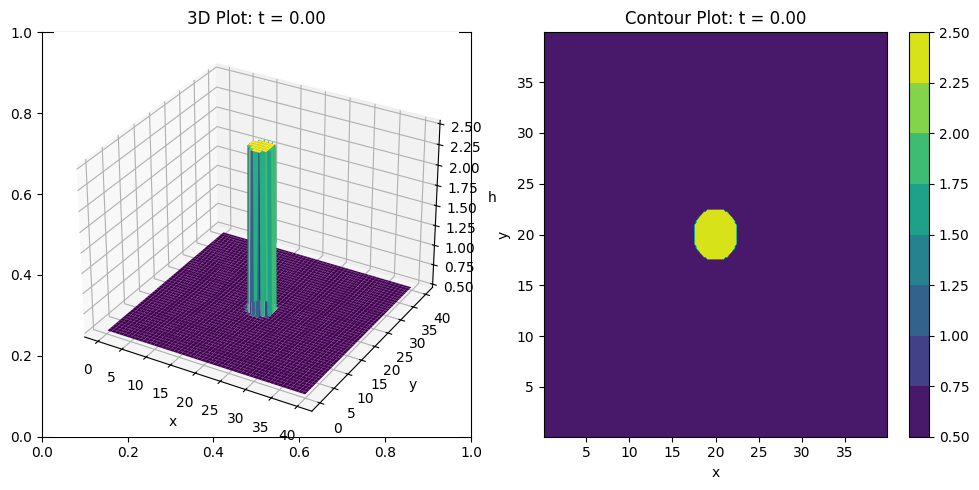

In [20]:
# Global constants
g = 9.81  # gravity
Nx = 200
Ny = Nx
xL, xR = 0, 40
yL, yR = 0, 40
t = 0
tend = 0.0 # 1 
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Center
xc = 20
yc = 20

# Radius
R = 2.5

# Initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)
for i in range(Nx):
    for j in range(Ny):
        r = np.sqrt((x[i] - xc)**2 + (y[j] - yc)**2)
        if r < R:
            Q[0, i, j] = 2.5
        else:
            Q[0, i, j] = 0.5


# Plot the initial data in 3d and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap='viridis')
ax1.set_title(f'3D Plot: t = {t:.2f}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('h')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap='viridis')
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Contour Plot: t = {t:.2f}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Show the combined plot
plt.tight_layout()
plt.show()

In [21]:
# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)

    # Update time and solution
    t += dt
    Q = np.copy(Qnew)

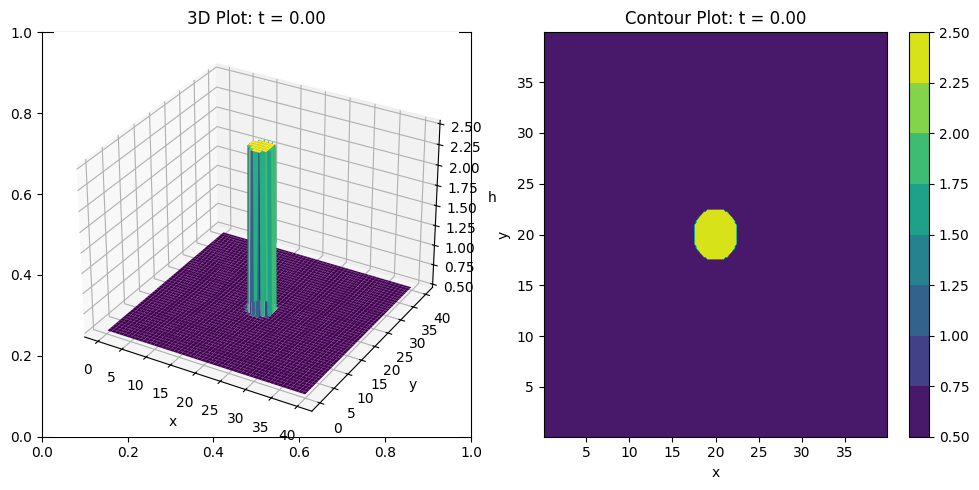

In [22]:
save = 1

# Plot the final data in 3D and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap='viridis')
ax1.set_title(f'3D Plot: t = {t:.2f}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('h')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap='viridis')
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Contour Plot: t = {t:.2f}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()

# Save figure
if save:
    filename = f'plots/toro2D_t={tend}.pdf'
    plt.savefig(filename, format='pdf')

plt.show()